# Week 10 Assignment

In this week's lecture lab we examined two dimensionality reduction techniques, Principal Component Analysis (PCA) and the Autoencoder. In this assignment we will explore additional functionalities of the Autoencoder and demonstrate its incredible versatility.

# Part A - Imports and Data Prep

All required imports have been made for you.

In [1]:
# Import tensorflow - 
# You can use: 
# pip install tensorflow
# to install these packages
# make sure that you have seaborn version 0.11.0 installed 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy.random import normal
from tensorflow.keras.datasets.mnist import load_data
import random
random.seed(100)
plt.style.use('seaborn')
from torch.utils.data import TensorDataset

# Part B - Noise Reduction

The autoencoder serves many purposes. You have already seen its ability to perform dimensionality reduction and now you will see how it can perform noise reduction. 

# Q1 List an additional functionality or potential use of an autoencoder (that has not been mentioned yet) in the space provided below. (5 marks)

Autoencoders can also be used to synthesize populations. From a small sample of the approximated distribution, a new synthesized population can be generated with similar properties to the original population.

# Q2 (30 marks)
To illustrate the ability of our autoencoder to reduce noise we will be using image data. Use the `load_data` function with the path attribute set to "mnist.npz". (Check documentation: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) You only care about the image data so you need to extract the training images from the imported data and get rid of the labels. Ensure your pixel values are between 0 and 1 and save this to the variable X_2

To simulate a noisy image, we will be adding white Gaussian noise to the data. To do this, you will need to use the normal function with a mean of 0 and a variance of 0.1. Cycle through the images in X_2, add noise, and save to a variable called X_2_noise.

Display the first image in X_2 and the first image in X_2_noise to see the effect of the noise you added. You can use the `sns.imshow` function for this.

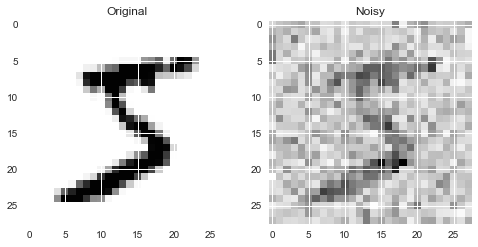

In [2]:
data = load_data(path='mnist.npz')

norm_coef = 1/255 # dividing all values by 255 such that the pixel values are between 0 and 1.
# Putting all pixel values between 0 and 1
X_2 = data[0][0] * norm_coef
X_2.shape

# Adding Gaussian noise with mean = 0 and variance 0.1
Noise = np.random.normal(0,np.sqrt(0.1),(X_2.shape))
X_2_noise = X_2 + Noise

# Plotting the two images side by side
fig, axs = plt.subplots(1,2)
axs[0].imshow(X_2[0])
axs[0].set(title="Original")
axs[1].imshow(X_2_noise[0])
axs[1].set(title="Noisy")
plt.show()

# Q3 Create an autoencoder to de-noise the image. You are responsible for selecting an appropriate design for the autoencoder. To speed up your training, for each iteration, train on a small subset of the data. (40 marks)

In this setting, it is useful to train a slight variation on the autoencoder that takes a noisy image as input and has the original (non-noisy) image as its target. You can then use this model to de-noise future images. Note that you will have to take care of re-shaping the images into tensors as you use the `from_numpy` function. 

In [3]:
# Flatten images into vectors
X_2_noise_flat = X_2_noise.reshape(X_2_noise.shape[0], X_2_noise.shape[1] * X_2_noise.shape[2]).astype(np.float32)
X_2_flat = X_2.reshape(X_2_noise.shape[0], X_2_noise.shape[1] * X_2_noise.shape[2]).astype(np.float32)

# Build Model. Reduce features to 500
auto_enc = nn.Sequential(
    nn.Linear(X_2_flat.shape[1], 500),
    nn.Hardtanh(),
    nn.Linear(500, X_2_flat.shape[1])
)

# define loss funciton. Using L1 loss because all values are between 0 and 1, so this is actually of higher magnitude than MSE.
loss_fn = torch.nn.L1Loss()

# define learning rate
learning_rate=2.5e-1

# Convert image encodings into tensors.
X_2_noise_flat = torch.from_numpy(X_2_noise_flat)
X_2_flat = torch.from_numpy(X_2_flat)

for t in range(10000):
    
    # Getting a small random sample of data.
    sample_rate = 0.01
    sample_size = round(X_2_flat.shape[0] * sample_rate)
    
    # Randomly choosing indices of images to use.
    indices = np.random.choice(X_2_flat.shape[0], size=sample_size, replace=False)
    
    # Getting the noisy and original versions of the random selected set of images.
    X_2_sample = np.zeros((sample_size, X_2_flat.shape[1]))
    X_2_noise_sample = np.zeros((sample_size, X_2_flat.shape[1]))
    for i in range(len(indices)):
        X_2_sample[i,:] = X_2_flat[indices[i]] 
        X_2_noise_sample[i,:] = X_2_noise_flat[indices[i]]
    
    # Converting these image encodings into tensors.
    X_2_sample = X_2_sample.astype(np.float32)
    X_2_sample = torch.from_numpy(X_2_sample)
    X_2_noise_sample = X_2_noise_sample = X_2_noise_sample.astype(np.float32)
    X_2_noise_sample = torch.from_numpy(X_2_noise_sample)
    
    # Getting predicted value, comparing to de-noisy image
    y_pred = auto_enc(X_2_noise_sample)
    loss = loss_fn(y_pred, X_2_sample)
    if t % 1000 == 999:
        print(t+1, loss.item())
        
    # Iterating on values    
    auto_enc.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad


1000 0.13435247540473938
2000 0.1072535514831543
3000 0.0928550511598587
4000 0.08324026316404343
5000 0.07571836560964584
6000 0.07054516673088074
7000 0.06790725886821747
8000 0.0670008659362793
9000 0.06589744985103607
10000 0.06379389762878418


# Q4 (25 marks)
### Pass the noisy images through your trained denoiser. (Often in practice we would evaluate a de-noiser using new test data, but to keep things simple for this assignment we will re-use the noised training data.)

### Plot histograms of the image noise (i.e. all of the pixel-by-pixel differences from the original image) before and after the use of the denoiser (You can use a subset of the data to reduce the time it takes to generate). 

### Display three images: an image of a noisy sample, an image of the sample after denoising, and an image the corresponding original (noise-free) sample.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


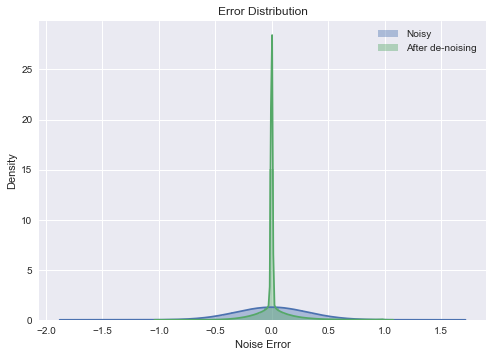

In [7]:
# Pass the data through
y_pred = auto_enc(X_2_noise_flat)






# Plot the histograms
pre_noise = X_2_flat - X_2_noise_flat
post_noise = X_2_flat - y_pred.detach().numpy()

    
# Plotting histograms

sns.distplot(pre_noise, label="Noisy")
sns.distplot(post_noise, label="After de-noising")
plt.xlabel("Noise Error")
plt.title("Error Distribution")
plt.legend()






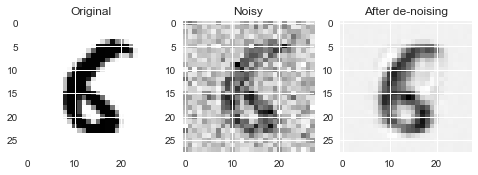

In [5]:
# Get a random image to show
index = np.random.choice(X_2_flat.shape[0], size=1)[0]

# De-flattening the random image selected
original = X_2_flat.detach().numpy().reshape(X_2.shape)[index,:,:]
noisy = X_2_noise_flat.detach().numpy().reshape(X_2.shape)[index,:,:]
denoised = y_pred.detach().numpy().reshape(X_2.shape)[index,:,:]

# Showing images.
fig, axs = plt.subplots(1,3)
axs[0].imshow(original)
axs[0].title.set_text("Original")
axs[1].imshow(noisy)
axs[1].title.set_text("Noisy")
axs[2].imshow(denoised)
axs[2].title.set_text("After de-noising")

plt.show()
# Display the three images

# Congratulations you have completed this week's assignment. Please remember to restart and run all cells before submitting.